![eagle](../../eagleeye/eagle_eye_log.jpeg)


# Generate results

In [4]:
"""
@author: Andre Scaffidi (AndreScaffidi)
@author: Sebastian Springer (sspringe137)

This is a notebook to create figures 2 and 8 from the paper

"""

# Download the LHC Olympics R&D data from Zenodo if you don't have it already. 
# https://zenodo.org/records/4536377
# Can then use load_the_data.py to create the npy file we use for analysis. 
# Current data file is in ./data/LHC_data1p1M_new_features.npy so don't need to do this step

!wget https://zenodo.org/records/6466204/files/events_anomalydetection_v2.features.h5?download=1 .
!mv 'events_anomalydetection_v2.features.h5?download=1' data/events_anomalydetection_v2.features.h5


--2024-10-29 11:07:20--  https://zenodo.org/records/6466204/files/events_anomalydetection_v2.features.h5?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74315238 (71M) [application/octet-stream]
Saving to: ‘events_anomalydetection_v2.features.h5?download=1’

events_anomalydetec 100%[===================>]  70.87M  36.9MB/s    in 1.9s    

2024-10-29 11:07:22 (36.9 MB/s) - ‘events_anomalydetection_v2.features.h5?download=1’ saved [74315238/74315238]

--2024-10-29 11:07:22--  http://./
Resolving . (.)... failed: Name or service not known.
wget: unable to resolve host address ‘.’
FINISHED --2024-10-29 11:07:22--
Total wall clock time: 2.3s
Downloaded: 1 files, 71M in 1.9s (36.9 MB/s)


In [1]:
"""
Read the data and partitian the features as per Sec. 3.2 of the paper.
The result is a numpy array with columns corresponding to 
['|p|1', '|p|2', 'tau21j1', 'tau21j2', 'tau32j1', 'tau32j2' , 'mj1', 'mj2', 'label']
"""
import pandas as pd
import numpy as np

file_path              = 'data/events_anomalydetection_v2.features.h5'
df_features            = pd.read_hdf(file_path)
# Feature engineering
df_features['|p|1']    = np.sqrt(np.sum(df_features[['pxj1', 'pyj1', 'pzj1']]**2, axis=1))
df_features['|p|2']    = np.sqrt(np.sum(df_features[['pxj2', 'pyj2', 'pzj2']]**2, axis=1))
df_features['tau21j1'] = df_features['tau2j1']/df_features['tau1j1']
df_features['tau21j2'] = df_features['tau2j2']/df_features['tau1j2']
df_features['tau32j1'] = df_features['tau3j1']/df_features['tau2j1']
df_features['tau32j2'] = df_features['tau3j2']/df_features['tau2j2']

new_features           = ['|p|1', '|p|2', 'tau21j1', 'tau21j2', 'tau32j1', 'tau32j2']
df_features            = df_features[new_features + [col for col in df_features.columns if col not in new_features]]

LHC_data1p1M           = df_features.to_numpy()[ :, [0,1,2,3,4,5,9,16,20] ]

# Print the shape of the np array
LHC_data1p1M[np.isnan(LHC_data1p1M)]                  = 0     # Andre suggestion

np.save('data/LHC_data1p1M_new_features.npy',LHC_data1p1M)

In [17]:
"""
Run EagleEye

Here we have created the script 'run.sh' to run 'LHC_Olympics2020_EagleEye_DADM.py', which calls EagleEye and performs the anomaly detection
itteratevly over several anomaly injection percentages. 

Results are saved in the 'results' folder. 

NOTE: This process can require several CPU hours**
"""

!bash run.sh



Running with anomaly size: 2500
^C


# Read results

The results files `LHC_EagleEye_results_500000_anomaly_size*` generated with `LHC_Olympics2020_EagleEye_DADM.py` contain the following entries:

>                Keys:           


>                binary_sequences, 
>                neighbourhood_indexes
>                mixed_samples
>                reference_samples
>                kstar_
>                NLPval
>                lables 
>                anomaly_size
           
                 


In [14]:
# Loading the results from EagleEye
pvals = {}
results_dir           = 'results/'
pvals['anom+b_10k']   = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_10000_kstar_range_4_999_.npz'%results_dir)
pvals['anom+b_2.5k']  = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_2500_kstar_range_4_999_.npz'%results_dir)
pvals['anom+b_1.75k'] = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_1750_kstar_range_4_999_.npz'%results_dir) 
pvals['anom+b_1.5k']  = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_1500_kstar_range_4_999_.npz'%results_dir)
pvals['anom+b_1.25k'] = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_1250_kstar_range_4_999_.npz'%results_dir)
pvals['anom+b_1.1k']  = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_1100_kstar_range_4_999_.npz'%results_dir)
pvals['anom+b_1.3k']  = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_1300_kstar_range_4_999_.npz'%results_dir)
pvals['anom+b_1.4k']  = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_1400_kstar_range_4_999_.npz'%results_dir)
pvals['anom+b_1k']    = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_1000_kstar_range_4_999_.npz'%results_dir)
pvals['anom+b_0.5k']  = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_500_kstar_range_4_999_.npz'%results_dir)
pvals['anom+b_0.3k']  = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_300_kstar_range_4_999_.npz'%results_dir)
pvals['anom+b_0']     = np.load('%s/LHC_EagleEye_results_500000_anomaly_size_0_kstar_range_4_999_.npz'%results_dir)

# Get all the labelled P vals
# Keep in mind that the ammount of bkg used here is 500k minus the ammount of injected  anomaly
def get_s_and_b(pvals):
    lnP_s_b = pvals['NLPval']
    mask_s  = pvals['lables_mix'] == 1
    mask_b  = pvals['lables_mix'] == 0
    lnP_b0  = lnP_s_b[mask_b]
    lnP_s   = lnP_s_b[mask_s]
    lnP_s   = lnP_s[lnP_s!=np.inf]
    lnP_s_b = lnP_s_b[lnP_s_b!=np.inf]
    lnP_b0  = lnP_b0[lnP_b0!=np.inf]
    return lnP_s,lnP_b0,lnP_s_b

lnP_s10k,lnP_b010k,lnP_s_b10k    = get_s_and_b(pvals['anom+b_10k'])
lnP_s2k5,lnP_b02k5,lnP_s_b2k5    = get_s_and_b(pvals['anom+b_2.5k'])
lnP_s1k5,lnP_b01k5,lnP_s_b1k5    = get_s_and_b(pvals['anom+b_1.5k'])
lnP_s1k75,lnP_b01k75,lnP_s_b1k75 = get_s_and_b(pvals['anom+b_1.75k'])
lnP_s1k,lnP_b01k,lnP_s_b1k       = get_s_and_b(pvals['anom+b_1k'])
lnP_s1k25,lnP_b01k25,lnP_s_b1k25 = get_s_and_b(pvals['anom+b_1.25k'])
lnP_s1k3,lnP_b01k3,lnP_s_b1k3    = get_s_and_b(pvals['anom+b_1.3k'])
lnP_s1k4,lnP_b01k4,lnP_s_b1k4    = get_s_and_b(pvals['anom+b_1.4k'])
lnP_s1k1,lnP_b01k1,lnP_s_b1k1    = get_s_and_b(pvals['anom+b_1.1k'])
lnP_sk5,lnP_b0k5,lnP_s_b0k5      = get_s_and_b(pvals['anom+b_0.5k'])
# Reserve a test set comprisiong only of background events
lnP_b                            = pvals['anom+b_0']['NLPval']



# Figure 2

In [15]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
#%% clustering

from dadapy import Data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph
def percentage_of_anomaly(anom_number):
    return  (anom_number/(500000 - anom_number))*100
def get_mixed_samples(data_dict):
    # Extract mixed_samples and NLPval\
    nlpval            = data_dict['NLPval']
    sorted_indices    = np.argsort(nlpval)
    nlpval            = nlpval[sorted_indices]
    mixed_samples     = data_dict['mixed_samples'][sorted_indices]
    reference_samples = data_dict['reference_samples'][sorted_indices]
    labels            = data_dict['lables_mix'][sorted_indices]
    mask              = (labels == 1)
    filtered_samples  = mixed_samples[mask]
    return mixed_samples ,nlpval ,reference_samples,filtered_samples,labels

mixed_samples10k,NLPval10k, reference_samples10k    , filtered_samples10k,labels10k    = get_mixed_samples(pvals['anom+b_10k'])
mixed_samples2_5k,NLPval2_5k,reference_samples2_5k  , filtered_samples2_5k,labels2_5k   = get_mixed_samples(pvals['anom+b_2.5k'])
mixed_samples1_5k,NLPval1_5k,reference_samples1_5,    filtered_samples1_5k,labels1_5k   = get_mixed_samples(pvals['anom+b_1.5k'])

# Set upsilon threshold
lllim = 14.0

def make_clusters(mixed_samples,NLPval):
    X     = mixed_samples[NLPval>lllim,:]
    NLPval_filtered = NLPval[NLPval > lllim]
    data  = Data(X, verbose=True)
    # Adjust maxk based on the number of samples
    adjusted_maxk = min(100, X.shape[0] - 1)
    data.compute_distances(maxk=adjusted_maxk)
    data.compute_id_2NN()
    data.compute_density_kstarNN()
    data.compute_clustering_ADP(Z=2.2, halo=True)
    cluster_ass        = data.cluster_assignment[data.cluster_assignment>-1]
    Nclus_m            = len(data.cluster_centers)
    cmap               = plt.get_cmap("gist_rainbow", Nclus_m)
    # Compute cluster sizes
    unique, counts = np.unique(cluster_ass, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    mix_clustered_     = np.squeeze(X[data.cluster_assignment[:] != -1,:])
    mix_clustered_halo = np.squeeze(X[data.cluster_assignment[:] == -1,:])
    NLPval_clustered   = np.squeeze(NLPval_filtered[data.cluster_assignment[:] != -1])
    return X, mix_clustered_,mix_clustered_halo,Nclus_m,cmap,cluster_ass,NLPval_clustered

X10, mix_clustered_10k, mix_clustered_halo_10k, Nclus_m10k, cmap10k, cluster_ass_10k, NLPval_clustered_10k = make_clusters(mixed_samples10k, NLPval10k)
X2_5, mix_clustered_2_5k, mix_clustered_halo_2_5k, Nclus_m2_5k, cmap2_5k, cluster_ass_2_5k, NLPval_clustered_2_5k = make_clusters(mixed_samples2_5k, NLPval2_5k)
X1_5, mix_clustered_1_5k, mix_clustered_halo_1_5k, Nclus_m1_5k, cmap1_5k, cluster_ass_1_5k, NLPval_clustered_1_5k = make_clusters(mixed_samples1_5k, NLPval1_5k)




Computation of distances started
Computation of the distances up to 100 NNs started
1.22 seconds for computing distances
ID estimation finished: selecting ID of 7.091331496671922
kstar estimation started, Dthr = 23.92812698
0.04 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.009 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.010 sec
Number of clusters before multimodality test= 30
Identification of the saddle points:  0.023 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0011022090911865234 sec
Clustering finished, 2 clusters found
total time is, 0.044741153717041016
Computation of distances started
Computation of the distances up to 100 NNs started
0.12 seconds for computing distances
ID estimation finished: selecting ID of 6.69525971795018
kstar

/tmp/ipykernel_1906512/1663374133.py:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar0.set_ticklabels(xtick_labels)  # Set the ticks back
/tmp/ipykernel_1906512/1663374133.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar11.set_ticklabels(xtick_labels)  # Set the ticks back
/tmp/ipykernel_1906512/1663374133.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar12.set_ticklabels(xtick_labels)  # Set the ticks back
/tmp/ipykernel_1906512/1663374133.py:259: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_statistic, critical_values, pval_ad = anderson_ksamp([lnP_s_b, lnP_b])
/tmp/ipykernel_1906512/1663374133.py:259: UserWarning: p-val

p_value 0.5: 1.0637379865841012e-11


/tmp/ipykernel_1906512/1663374133.py:259: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_statistic, critical_values, pval_ad = anderson_ksamp([lnP_s_b, lnP_b])


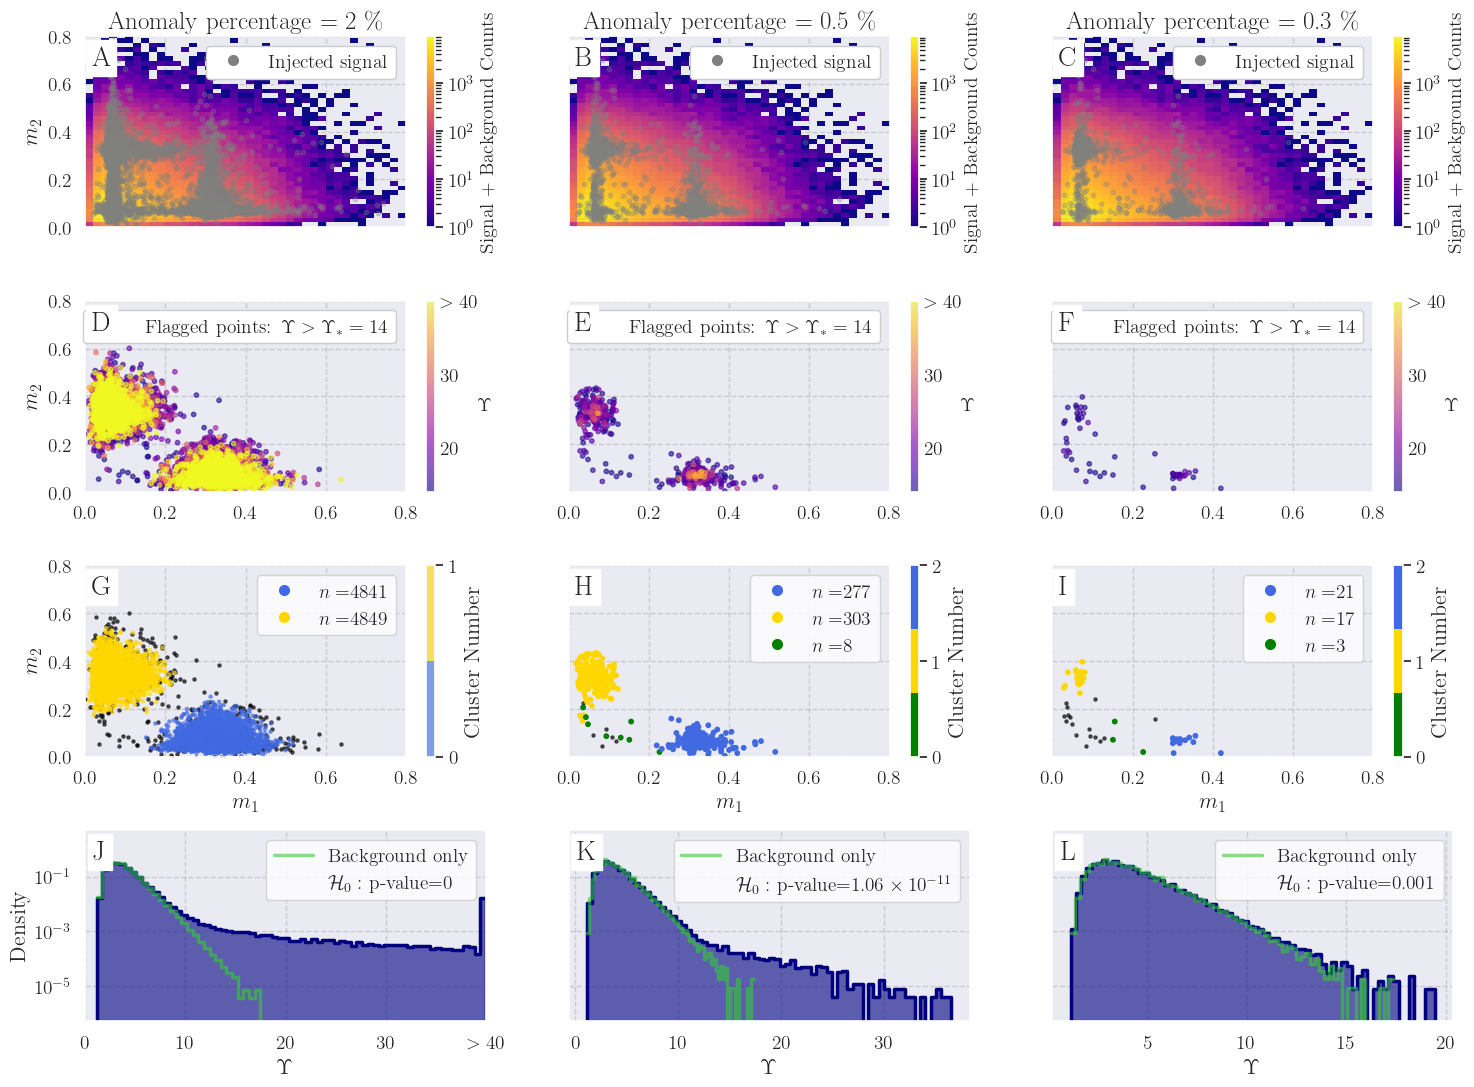

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde, norm
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

def set_custom_style():
    sns.set(style="darkgrid")
    plt.rcParams.update({
        'figure.figsize': (22, 25),
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'font.family': 'serif',
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
        'grid.color': 'gray',
        'text.usetex': True,
    })
set_custom_style()

colors = ['navy', 'darkorange', 'limegreen', 'magenta', 'red']
features = [6,7]


# Create a 2x3 plot (transposed layout)
fig, axs = plt.subplots(nrows=4, ncols=3,figsize=(15, 12))
axislim = [0, 0.8]

first_row_label = "Injected signal"

# First row - initial code
heatmap = axs[0, 0].hist2d(mixed_samples10k[:, features[0]], mixed_samples10k[:, features[1]], bins=50, cmap='plasma', norm=LogNorm())
cbar00 = plt.colorbar(heatmap[3], ax=axs[0, 0], norm=LogNorm())
cbar00.set_label('Signal + Background Counts', fontsize=14)
axs[0, 0].scatter(filtered_samples10k[:,     features[0]], filtered_samples10k[:,    features[1]], s=10.0, c='gray', alpha=0.3)
darker_dot = Line2D([0], [0], marker='o', linestyle='None',color='gray', markerfacecolor='gray', markersize=7, label=first_row_label)
axs[0, 0].legend(handles=[darker_dot],facecolor='white',framealpha=1)
axs[0, 0].set_xlim(axislim)
axs[0, 0].set_ylim(axislim)

heatmap = axs[0, 1].hist2d(mixed_samples2_5k[:, features[0]], mixed_samples2_5k[:, features[1]], bins=50, cmap='plasma', norm=LogNorm())
cbar10 = plt.colorbar(heatmap[3], ax=axs[0, 1], norm=LogNorm())
cbar10.set_label('Signal + Background Counts', fontsize=14)
axs[0, 1].scatter(filtered_samples2_5k[:,     features[0]], filtered_samples2_5k[:,    features[1]], s=10.0, c='gray', alpha=0.3, label=first_row_label)
darker_dot = Line2D([0], [0], marker='o', linestyle='None',color='gray', markerfacecolor='gray', markersize=7, label=first_row_label)
axs[0, 1].legend(handles=[darker_dot],facecolor='white',framealpha=1)
axs[0, 1].set_xlim(axislim)
axs[0, 1].set_ylim(axislim)

heatmap = axs[0, 2].hist2d(mixed_samples1_5k[:, features[0]], mixed_samples1_5k[:, features[1]], bins=50, cmap='plasma', norm=LogNorm())
cbar20 = plt.colorbar(heatmap[3], ax=axs[0, 2], norm=LogNorm())
cbar20.set_label('Signal + Background Counts', fontsize=14)
axs[0, 2].scatter(filtered_samples1_5k[:,     features[0]], filtered_samples1_5k[:,    features[1]], s=10.0, c='gray', alpha=0.3, label=first_row_label)
# axs[0, 2].scatter(filtered_samples1_3k[:,     features[0]], filtered_samples1_3k[:,    features[1]], s=10.0, c='gray', alpha=0.3, label=first_row_label)


darker_dot = Line2D([0], [0], marker='o', linestyle='None',color='gray', markerfacecolor='gray', markersize=7, label=first_row_label)
axs[0, 2].legend(handles=[darker_dot],facecolor='white',framealpha=1)
axs[0, 2].set_xlim(axislim)
axs[0, 2].set_ylim(axislim)

# Set threshold of colourbar
vmin,vmax = lllim,40
greek     = 'Upsilon'

#####################################
# Second row
second_row_labek = r"Flagged points: $\%s > \%s_* =%d$" %(greek,greek,lllim)

sc1 = axs[1, 0].scatter(mixed_samples10k[:, features[0]][NLPval10k>vmin], mixed_samples10k[:, features[1]][NLPval10k>vmin], s=10.0, c=NLPval10k[NLPval10k>vmin], cmap='plasma', alpha=0.6, vmin=vmin, vmax=vmax, label=second_row_labek)

cbar0 = plt.colorbar(sc1, ax=axs[1, 0])
cbar0.set_label(r'$\%s$'%greek, fontsize=14,rotation=360)
axs[1, 0].legend(facecolor='white',framealpha=1)
axs[1, 0].set_xlim(axislim)
axs[1, 0].set_ylim(axislim)
axs[1, 0].set_ylabel(r'$m_{j2}$')

sc2 = axs[1, 1].scatter(mixed_samples2_5k[:, features[0]][NLPval2_5k>vmin], mixed_samples2_5k[:, features[1]][NLPval2_5k>vmin], s=10.0, c=NLPval2_5k[NLPval2_5k>vmin], cmap='plasma', alpha=0.6, vmin=vmin, vmax=vmax, label=second_row_labek)
cbar11 = plt.colorbar(sc2, ax=axs[1, 1])
cbar11.set_label(r'$\%s$'%greek, fontsize=14,rotation=360)
axs[1, 1].legend(facecolor='white',framealpha=1)
axs[1, 1].set_xlim(axislim)
axs[1, 1].set_ylim(axislim)
catter(mixed_samples1_5k[:, features[0]][NLPval1_5k>vmin], mixed_samples1_5k[:, features[1]][NLPval1_5k>vmin], s=10.0, c=NLPval1_5k[NLPval1_5k>vmin], cmap='plasma', alpha=0.6, vmin=vmin, vmax=vmax, label=second_row_labek)
sc3 = axs[1, 2].scatter(mixed_samples1_5k[:, features[0]][NLPval1_5k>vmin], mixed_samples1_5k[:, features[1]][NLPval1_5k>vmin], s=10.0, c=NLPval1_5k[NLPval1_5k>vmin], cmap='plasma', alpha=0.6, vmin=vmin, vmax=vmax, label=second_row_labek)


cbar12 = plt.colorbar(sc3, ax=axs[1, 2])
cbar12.set_label(r'$\%s$'%greek, fontsize=14,rotation=360)


# Change the last label to '>40'
# Modify the x-tick labels
xticks = cbar12.get_ticks()  # Get current x-tick positions
xtick_labels = [f"{int(x)}" for x in xticks]  # Convert them to strings
xtick_labels[-1] = r'$>%d$' %int(vmax)
cbar0.set_ticklabels(xtick_labels)  # Set the ticks back
cbar11.set_ticklabels(xtick_labels)  # Set the ticks back
cbar12.set_ticklabels(xtick_labels)  # Set the ticks back

cbar12.ax.tick_params(length=0)
cbar11.ax.tick_params(length=0)
cbar0.ax.tick_params(length=0)


axs[1, 2].legend(facecolor='white',framealpha=1)
axs[1, 2].set_xlim(axislim)
axs[1, 2].set_ylim(axislim)


#################################################
# Plotting results of clustering
from matplotlib.colors import ListedColormap, BoundaryNorm
colorsss = ['royalblue', 'gold' , 'green', 'purple',  'cyan']
# Find the unique number of clusters (ignoring any invalid cluster assignments like -1)
# Create a colormap using only as many colors as the number of unique clusters
cmap = ListedColormap(colorsss[:2])
# mask_clusters_10k = # Get rid of lowest populated cluster
axs[2, 0].scatter(mix_clustered_halo_10k[:,features[0]],mix_clustered_halo_10k[:,features[1]], s=5.0, c='black', alpha=0.6)
sc4 = axs[2, 0].scatter(mix_clustered_10k[:,features[0]],mix_clustered_10k[:,features[1]], s=5.0, c=cluster_ass_10k, alpha=0.6,cmap=cmap)
axs[2, 0].set_xlim(axislim)
axs[2, 0].set_ylim(axislim)
# Add colorbar
cbar = fig.colorbar(sc4, ax=axs[2, 0], ticks=range(Nclus_m10k))
cbar.set_label('Cluster Number')

# Custom legend handles
# circle1 = mpatches.Patch(color='green', label=r'$n = %d$'  )
circle2 = Line2D([0], [0], marker='o', linestyle='None',color='gold', markerfacecolor='gold', markersize=7, label=r'$n = $%d' %len(cluster_ass_10k[cluster_ass_10k==1]))
circle3 = Line2D([0], [0], marker='o', linestyle='None',color='royalblue', markerfacecolor='royalblue', markersize=7,label=r'$n = $%d' %len(cluster_ass_10k[cluster_ass_10k==0]))
# Add the legend with the new circle handles
axs[2, 0].legend(facecolor='white', handles=[ circle3, circle2], loc='upper right')

# Plotting results of clustering for 2_5k
# Switch 0 and 2s in cluster_ass_2_5k
colorsss = ['green', 'gold' ,'royalblue' , 'purple',  'cyan']


mask_clusters_2_5k = np.where(cluster_ass_2_5k!=0)[0]
mask_clusters_2_5k = range(len(mask_clusters_2_5k)) # Comment this out to have two most sig cluster

num_unique_clusters_2_5k = len(np.unique(cluster_ass_2_5k[mask_clusters_2_5k]))
cmap                      = ListedColormap(colorsss[:num_unique_clusters_2_5k])


# Custom legend handles
# circle1 = mpatches.Patch(color='green', label=r'$n = %d$'  )
circle1 = Line2D([0], [0], marker='o', linestyle='None',color='green', markerfacecolor='green', markersize=7, label=r'$n = $%d' %len(cluster_ass_2_5k[cluster_ass_2_5k==0]))
circle2 = Line2D([0], [0], marker='o', linestyle='None',color='gold', markerfacecolor='gold', markersize=7, label=r'$n = $%d' %len(cluster_ass_2_5k[cluster_ass_2_5k==1]))
circle3 = Line2D([0], [0], marker='o', linestyle='None',color='royalblue', markerfacecolor='royalblue', markersize=7,label=r'$n = $%d' %len(cluster_ass_2_5k[cluster_ass_2_5k==2]))
# Add the legend with the new circle handles
axs[2, 1].legend(facecolor='white', handles=[ circle3, circle2, circle1], loc='upper right')


axs[2, 1].scatter(mix_clustered_halo_2_5k[:,      features[0]], mix_clustered_halo_2_5k[:, features[1]], s=5.0, c='black', alpha=0.6)
sc_2_5k = axs[2,1].scatter(mix_clustered_2_5k[:, features[0]][mask_clusters_2_5k], mix_clustered_2_5k[:,      features[1]][mask_clusters_2_5k], s=10.0, c=cluster_ass_2_5k[mask_clusters_2_5k], alpha=1, cmap=cmap)


axs[2, 1].set_xlim(axislim)
axs[2, 1].set_ylim(axislim)
# Add colorbar
cbar_2_5k = fig.colorbar(sc_2_5k, ax=axs[2, 1], ticks=range(Nclus_m2_5k))
cbar_2_5k.set_label('Cluster Number')


colorsss = ['green', 'gold' ,'royalblue' , 'purple',  'cyan']

mask_clusters_1_5k = np.where(cluster_ass_1_5k!=0)[0]
mask_clusters_1_5k = range(len(mask_clusters_1_5k)) # Comment this out to have two most sig cluster
num_unique_clusters_1_5k = len(np.unique(cluster_ass_1_5k[mask_clusters_1_5k]))
cmap                 = ListedColormap(colorsss[:num_unique_clusters_1_5k])

# Custom legend handles
# circle1 = mpatches.Patch(color='green', label=r'$n = %d$'  )
circle1 = Line2D([0], [0], marker='o', linestyle='None',color='green', markerfacecolor='green', markersize=7, label=r'$n = $%d' %len(cluster_ass_1_5k[cluster_ass_1_5k==0]))
circle2 = Line2D([0], [0], marker='o', linestyle='None',color='gold', markerfacecolor='gold', markersize=7, label=r'$n = $%d' %len(cluster_ass_1_5k[cluster_ass_1_5k==1]))
circle3 = Line2D([0], [0], marker='o', linestyle='None',color='royalblue', markerfacecolor='royalblue', markersize=7,label=r'$n = $%d' %len(cluster_ass_1_5k[cluster_ass_1_5k==2]))


# Add the legend with the new circle handles
axs[2, 2].legend(facecolor='white', handles=[ circle3, circle2, circle1], loc='upper right')


axs[2, 2].scatter(mix_clustered_halo_1_5k[:,      features[0]], mix_clustered_halo_1_5k[:, features[1]], s=5.0, c='black', alpha=0.6)
sc_1_5k = axs[2, 2].scatter(mix_clustered_1_5k[:, features[0]][mask_clusters_1_5k], mix_clustered_1_5k[:,      features[1]][mask_clusters_1_5k], s=10.0, c=cluster_ass_1_5k[mask_clusters_1_5k], alpha=1, cmap=cmap)
# axs[2, 2].scatter(mix_clustered_halo_1_25k[:,      features[0]], mix_clustered_halo_1_25k[:, features[1]], s=5.0, c='black', alpha=0.6)
# sc_1_3k = axs[2, 2].scatter(mix_clustered_1_3k[:, features[0]], mix_clustered_1_3k[:,      features[1]], s=10.0, c=cluster_ass_1_3k, alpha=1, cmap=cmap_1_3k)

axs[2, 2].set_xlim(axislim)
axs[2, 2].set_ylim(axislim)

# Add colorbar
cbar_1_5k = fig.colorbar(sc_1_5k, ax=axs[2, 2], ticks=range(Nclus_m1_5k))
# cbar_1_3k = fig.colorbar(sc_1_3k, ax=axs[2, 2], ticks=range(Nclus_m1_3k))

cbar_1_5k.set_label('Cluster Number')
# cbar_1_3k.set_label('Cluster Number')



from scipy.stats import ks_2samp, anderson_ksamp,cramervonmises_2samp

def percentage_of_anomaly(anom_number):
    return  (anom_number/(500000 - anom_number))*100


import seaborn as sns

def plot_H0rej_ax(ax, lnP_b, lnP_s_b, cut_last_bin=False,NLPval_clustered=None,cluster_ass=None):
    thresh = 24
    # ax.axvline(thresh, color='red', linestyle='--', linewidth=2, label='Crit. value')
    # Check if we need to cut the last bin
    if cut_last_bin:

        # Set the bins with the last bin limited to 100
        bins = np.linspace(min(min(lnP_s_b), min(lnP_b)), cut_last_bin, 70)

        # Append points greater than 100 into the last bin
        lnP_s_b = np.clip(lnP_s_b, bins[0], cut_last_bin)
        lnP_b = np.clip(lnP_b, bins[0], cut_last_bin)
        ax.set_xlim(0,cut_last_bin)
        
    else:
        # Use regular bins if cut_last_bin is False
        bins = 70

    # Plot the histograms
    sns.histplot(lnP_s_b, bins=bins, kde=False, stat='density', color='navy', element='step', linewidth=2.5, alpha=0.6, ax=ax)
    sns.histplot(lnP_b, bins=bins, kde=False, stat='density', label='Background only', color='limegreen', element='step', linewidth=2.5, alpha=0.6, ax=ax, fill=False)



    # Remove y-axis label
    ax.set_ylabel('')

    # Set y-axis to log scale
    ax.set_yscale('log')

    # Perform KS test
    ks_statistic, p_value = ks_2samp(lnP_s_b, lnP_b)

    # Perform Anderson-Darling test
    ad_statistic, critical_values, pval_ad = anderson_ksamp([lnP_s_b, lnP_b])

    # Add a function for Cramér-von Mises test
    def cvm_test_pvalue(lnP_s, lnP_b, threshold=0):
        s_binary = lnP_s[lnP_s > threshold]
        b_binary = lnP_b[lnP_b > threshold]
        result = cramervonmises_2samp(s_binary, b_binary)
        return result.pvalue
    
    # Perform Cramér-von Mises test
    p_value = cvm_test_pvalue(lnP_s_b, lnP_b, threshold=0)

    # Add text to the plot with LaTeX formatting
    p_value_exp = int(np.floor(np.log10(p_value)))
    pp = p_value / 10**p_value_exp

    
    # Display CVM p-value
    pval_string = 'CVM'
    pval_string = r'$\mathcal{H}_0:$'
    if cut_last_bin:
        text_label = r'%s p-value=0' %pval_string
    elif -50 < p_value < 1E-6:
        print(f"p_value 0.5: {p_value}")
        text_label = r'%s p-value=$%1.2F\times10^{%d}$' % (pval_string,pp, p_value_exp)
    else:
        text_label = r'%s p-value=$0.001$' %pval_string
    # Create a custom legend entry for the text
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='white', alpha=0, label=text_label)]

    # Add the custom legend entry to the existing legend
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(custom_lines)
    ax.legend(handles=handles, loc='upper right',facecolor='white')
    ax.set_ylim(5E-7,5 )

    # Modify the x-tick labels
    xticks = ax.get_xticks()  # Get current x-tick positions
    xtick_labels = [f"{int(x)}" for x in xticks]  # Convert them to strings

    # Change the last label to '>100'
    if cut_last_bin:
        xtick_labels[-1] = r'$>%d$' %int(cut_last_bin)
        ax.set_xticks(xticks)  # Set the ticks back
        ax.set_xticklabels(xtick_labels)  # Set the new labels


    if NLPval_clustered is not None:
        # Plot a vertical line for each element of NPval_clustered
        for val in [max(NLPval_clustered[cluster_ass==0])]:
            ax.axvline(val, color='red', linestyle='--', linewidth=3, alpha=1,label=r'Max $\Upsilon$: cluster 0')
        for val in [max(NLPval_clustered[cluster_ass==1])]:
            ax.axvline(val, color='pink', linestyle='--', linewidth=3, alpha=1,label=r'Max $\Upsilon$: cluster 1')


plot_H0rej_ax(axs[3, 0],lnP_b,lnP_s_b10k,cut_last_bin=40)
plot_H0rej_ax(axs[3, 1],lnP_b,lnP_s_b2k5,cut_last_bin=False)
plot_H0rej_ax(axs[3, 2],lnP_b,lnP_s_b1k5,cut_last_bin=False)


#################################################
# Axis adjusting
# Remove x-ticks for the first row and y-ticks for the last two columns
for ax in axs[0, :]:
    ax.set_xticklabels([])
for ax in axs[:, 1:].flat:
    ax.set_yticklabels([])

# Adding labels to each subplot
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
for ax, label in zip(axs.flat, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='left', zorder=10, bbox=dict(facecolor='white', edgecolor='white'))

# Main title for the figure
axs[2, 0].set_xlabel(r'$m_{1}$')
axs[2, 1].set_xlabel(r'$m_{1}$')
axs[2, 2].set_xlabel(r'$m_{1}$') 

axs[3, 0].set_xlabel(r'$\%s$'%greek)
axs[3, 1].set_xlabel(r'$\%s$'%greek)
axs[3, 2].set_xlabel(r'$\%s$'%greek) 

axs[0, 0].set_ylabel(r'$m_{2}$')
axs[1, 0].set_ylabel(r'$m_{2}$')
axs[2, 0].set_ylabel(r'$m_{2}$')
axs[3, 0].set_ylabel(r'$\textrm{Density}$')


axs[0, 0].set_title(r'Anomaly percentage = 2 \%%' )
axs[0, 1].set_title(r'Anomaly percentage = %.1f $\%%$' % percentage_of_anomaly(2.5E3))
axs[0, 2].set_title(r'Anomaly percentage = %.1f $\%%$' % percentage_of_anomaly(1.5E3))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to include the main title


plt.show()


# Figure 8 (Supplementary inforamtion) 


/tmp/ipykernel_1906512/4183525975.py:42: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, significance_level = anderson_ksamp([s_binary, b_binary])
/tmp/ipykernel_1906512/4183525975.py:42: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, critical_values, significance_level = anderson_ksamp([s_binary, b_binary])


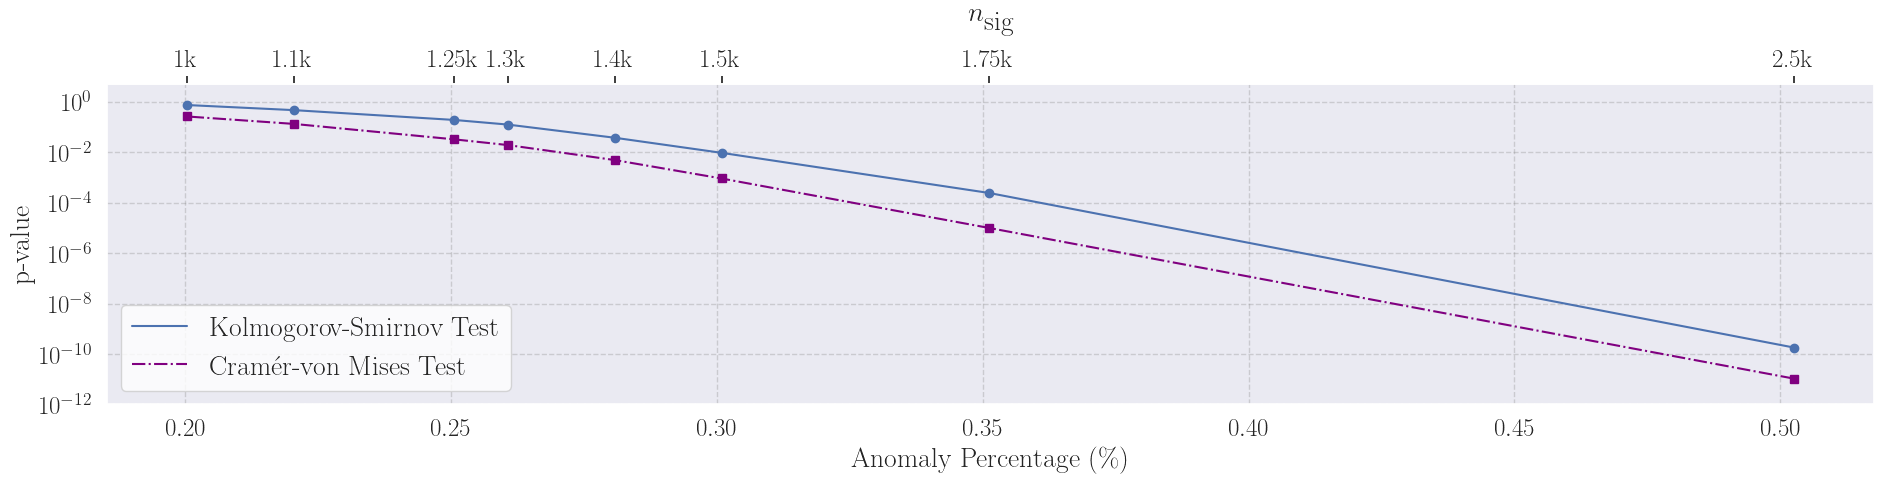

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, anderson_ksamp, cramervonmises_2samp
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.lines as mlines

def percentage_of_anomaly(anom_number):
    return  (anom_number/(500000 - anom_number))*100

dist_list = [
    (lnP_b, lnP_s_b2k5,  2.5E3 , percentage_of_anomaly(2.5E3 ) ),
    (lnP_b, lnP_s_b1k75, 1.75E3, percentage_of_anomaly(1.75E3) ),
    (lnP_b, lnP_s_b1k5,  1.5E3 , percentage_of_anomaly(1.5E3 ) ),
    (lnP_b, lnP_s_b1k4,  1.4E3 , percentage_of_anomaly(1.4E3 ) ),
    (lnP_b, lnP_s_b1k3,  1.3E3 , percentage_of_anomaly(1.3E3 ) ),
    (lnP_b, lnP_s_b1k25, 1.25E3, percentage_of_anomaly(1.25E3) ),
    (lnP_b, lnP_s_b1k1,  1.1E3 , percentage_of_anomaly(1.1E3 ) ),
    (lnP_b, lnP_s_b1k,   1E3   , percentage_of_anomaly(1E3   ) ),
    # (lnP_b, lnP_s_b0k5,  500  , percentage_of_anomaly(500  ) ),
]

def ks_test_pvalue(lnP_s, lnP_b, threshold=0):
    s_binary = lnP_s[lnP_s > threshold]
    b_binary = lnP_b[lnP_b > threshold]
    ks_stat, p_value = ks_2samp(s_binary, b_binary)
    return p_value

def mutual_information_test_pvalue(lnP_s, lnP_b, threshold=0):
    s_binary = lnP_s[lnP_s > threshold]
    b_binary = lnP_b[lnP_b > threshold]
    joint_hist = np.histogram2d(s_binary, b_binary, bins=20)[0]
    joint_prob = joint_hist / np.sum(joint_hist)
    s_prob = np.sum(joint_prob, axis=1)
    b_prob = np.sum(joint_prob, axis=0)
    mutual_info = np.nansum(joint_prob * np.log(joint_prob / (s_prob[:, None] * b_prob[None, :] + 1e-10) + 1e-10))
    return mutual_info

def ad_test_pvalue(lnP_s, lnP_b, threshold=0):
    s_binary = lnP_s[lnP_s > threshold]
    b_binary = lnP_b[lnP_b > threshold]
    ad_stat, critical_values, significance_level = anderson_ksamp([s_binary, b_binary])
    return significance_level


# Add a function for Cramér-von Mises test
def cvm_test_pvalue(lnP_s, lnP_b, threshold=0):
    s_binary = lnP_s[lnP_s > threshold]
    b_binary = lnP_b[lnP_b > threshold]
    result = cramervonmises_2samp(s_binary, b_binary)
    return result.pvalue

# Modify plot_pvalues_vs_anomaly_percentage to include Cramér-von Mises p-value
def plot_pvalues_vs_anomaly_percentage(lnP_s_list, lnP_b_list, anomaly_percentages, threshold, color):
    ks_pvalues = []
    ad_pvalues = []
    mi_pvalues = []
    cvm_pvalues = []  # Store Cramér-von Mises p-values

    for lnP_s, lnP_b in zip(lnP_s_list, lnP_b_list):
        ks_pvalues.append(ks_test_pvalue(lnP_s, lnP_b, threshold))
        ad_pvalues.append(ad_test_pvalue(lnP_s, lnP_b, threshold))
        mi_pvalues.append(mutual_information_test_pvalue(lnP_s, lnP_b, threshold))
        cvm_pvalues.append(cvm_test_pvalue(lnP_s, lnP_b, threshold))  # Append Cramér-von Mises p-value

    return ks_pvalues, ad_pvalues, mi_pvalues, cvm_pvalues

# Plotting
lnP_s_list = [x[1] for x in dist_list]
lnP_b_list = [x[0] for x in dist_list]
anomaly_percentages = [x[3] for x in dist_list]
anomaly_sizes = [x[2] for x in dist_list]

colors = ['b', 'g', 'r', 'c', 'm', 'orange']

def set_custom_style():
    sns.set(style="darkgrid")
    plt.rcParams.update({
        'figure.figsize': (22, 20),
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 14,
        'font.family': 'serif',
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
        'grid.color': 'gray',
        'text.usetex': True,
    })

set_custom_style()

fig, ax1 = plt.subplots(figsize=(19, 5))
ax1.set_ylim(1E-12, 5)

for i, threshold in enumerate([0]):
    ks_pvalues, ad_pvalues, mi_pvalues, cvm_pvalues = plot_pvalues_vs_anomaly_percentage(lnP_s_list, lnP_b_list, anomaly_percentages, threshold, colors[i % len(colors)])
    ax1.plot(anomaly_percentages, ks_pvalues, marker='o', linestyle='-', color=colors[i % len(colors)], label=fr'KS')
    ax1.plot(anomaly_percentages, cvm_pvalues, marker='s', linestyle='-.', color='purple', label=fr'CVM')  # Plot Cramér-von Mises p-values

secax = ax1.secondary_xaxis('top')
secax.set_xlabel(r'$n_\textrm{sig}$', labelpad=20)
secax.set_xticks(anomaly_percentages[::-1])
secax.set_xticklabels(['1k', '1.1k', '1.25k', '1.3k', '1.4k', '1.5k', '1.75k', '2.5k'])

ax1.set_xlabel('Anomaly Percentage (\\%)')
ax1.set_ylabel('p-value')
ax1.set_yscale('log')

# ax1.axhline(y=0.01, color='k', linestyle='--', label=r'$p=0.05$')

# Custom legend handles
line1 = mlines.Line2D([], [], color='b', linestyle='-', label='Kolmogorov-Smirnov Test')
line2 = mlines.Line2D([], [], color='purple', linestyle='-.', label='Cramér-von Mises Test')
line4 = mlines.Line2D([], [], color='k', linestyle='--', label=r'$p_\textrm{thresh} = 0.05$')

# ax1.legend(facecolor='white', handles=[line1, line2, line4], loc='lower left', fontsize=20)
ax1.legend(facecolor='white', handles=[line1, line2], loc='lower left', fontsize=20)


plt.tight_layout()


plt.show()
